<a href="https://colab.research.google.com/github/AaryaDesai1/PDP_ICE_ALE/blob/main/PDP_ALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590- XAI | Assignment #06

## Aarya Desai

# Table of Contents


>[Table of Contents](#scrollTo=_Nl9xAx-Off1)

>[Setting up the Notebook](#scrollTo=sFqTBNnTPfD2)

>>[Installing necessary libraries](#scrollTo=XqaDkpBvNs5S)

>>[Importing the Libraries](#scrollTo=0DU9WRYAPSLB)

>>[Loading the data](#scrollTo=JxWHwvr2TmJK)

>>[Training the Model](#scrollTo=WPMkVvdhV_gy)

>[Explainable ML](#scrollTo=OPcCHp6IXpsE)

>>[Partial Dependence Plots (PDP):](#scrollTo=4Sr_dhRyXrLK)

>>>[What is a PDP?](#scrollTo=4Sr_dhRyXrLK)

>>>[How to use a PDP?](#scrollTo=4Sr_dhRyXrLK)

>>>[How to interpret a PDP?](#scrollTo=4Sr_dhRyXrLK)

>>>[Interpreting the PDP for Median Income](#scrollTo=3TFMaH4rlsL0)

>>>[Strengths and Weaknesses of PDPs](#scrollTo=CORU6QdilsL0)

>>[Individual Conditional Expectation (ICE) Plots](#scrollTo=c5o6Ar2XlsL0)

>>>[What is an ICE Plot?](#scrollTo=c5o6Ar2XlsL0)

>>>[How to use an ICE Plot?](#scrollTo=c5o6Ar2XlsL0)

>>>[How to interpret an ICE Plot?](#scrollTo=c5o6Ar2XlsL0)

>>>[Interpreting the ICE Plot for Median Income](#scrollTo=tpk-pQ6FlsL1)

>>>[Strengths and Weaknesses of ICE Plots](#scrollTo=ImBNBZkBlsL1)

>>[Accumulated Local Effects (ALE) Plots](#scrollTo=Z4fyfZiAlsL2)

>>>[What is an ALE Plot?](#scrollTo=Z4fyfZiAlsL2)

>>>[How to use an ALE Plot?](#scrollTo=Z4fyfZiAlsL2)

>>>[How to interpret an ALE Plot?](#scrollTo=Z4fyfZiAlsL2)

>>>[Interpreting the ALE Plot for Median Income](#scrollTo=sdpLuyfOlsL2)

>>>[Strengths and Weaknesses of ALE Plots](#scrollTo=na9_5PXQlsL2)



# Setting up the Notebook

## Installing necessary libraries
This was taken from Dr. Bent's `Global Explanations` demo notebook. Here, we are installing the following libraries:
- `numpy==1.25.2`: for numerical computations, specifically for large multi-dimensional arrays and matrices.
- `pandas==2.0.3`: for data manipulation and analyses.
- `scikit-learn==1.2.2`: a library for machine learning, data mining, analysis, and modeling. Here, it's also used to import the dataset we will be using.
- `shap==0.45.1`: A library for explaining machine learning models using SHAP values, which provide insights into feature importance.
- `alepython`: A library for calculating Accumulated Local Effects (ALE), a method used to understand the behavior of machine learning models by analyzing feature interactions.


In [2]:
!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev  # egg=alepython


  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-req-build-j__pym_l
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-req-build-j__pym_l
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.3 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=999456b49bbd053cb09fd75cf10e12030c50e5d683fe85ac3f9b776410b4d16f
  Stored in directory: /tmp/pip-ephem-wheel-cache-p6mxqvgy/wheels/80/2e/91/7f216caef9a7f0c6ce18ee562b6156df43b3a79f69a0c1f3d1
Successfully built alepython


## Importing the Libraries

The next step is to import all the libraries that were installed in the previous block (and a few more). The in-code comments give some extra information about what the libraries are for.

In [3]:
# For the model
from sklearn.ensemble import GradientBoostingRegressor

# For the data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For explainability
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance


## Loading the data  

**Dataset**: This dataset contains information about red wine quality, assessed by various chemical properties such as acidity, sugar content, and alcohol levels. It provides valuable insights into how these features interact to influence the quality of wine, making it ideal for interpretability analysis. Here, the `y` or outcome variable is the wine quality score, and the `X` or feature variables include columns such as `fixed acidity`, `volatile acidity`, `citric acid`, `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide`, `density`, `pH`, `sulphates`, and `alcohol`.

**Train-Test Split**: The data is then split into a train and test set to train the model on and test it respectively. A standard 80-20 split is used. I also set a random seed to make sure the same datapoints are in the train and test sets any time the cell is run to ensure consistency.

In [6]:
# Loading the data
wine_data = fetch_openml(name="wine-quality-red", as_frame=True)
df = wine_data.frame
df = df.rename(columns={'class': 'quality'})

# Splitting the data into train and test sets
X = df.drop('quality', axis=1)
y = df['quality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Training the Model

The model I chose to use for this demo is a `Gradient Boosting Regressor`, which is highly effective for structured and tabular data, like in this dataset.

Gradient Boosting builds an ensemble of decision trees sequentially, with each tree trying to correct the errors of the previous ones. This approach enhances the model’s accuracy but makes it harder to interpret the contributions of individual features directly. Therefore, explainable plots like PDP, ICE, and ALE are excellent tools to illustrate feature influences in this model and provide a deeper understanding of how it arrives at its predictions.

The following parameters were selected:
- `n_estimators = 100`: specifies the use of 100 decision trees to ensure a robust ensemble.
- `learning_rate = 0.1`: balances the contribution of each tree to prevent overfitting while maintaining model performance.
- `max_depth = 3`: limits the complexity of each tree, promoting generalization and interpretability in the predictions.

In [8]:
# Training the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

# Explainable ML

## Partial Dependence Plots (PDP):

### What is a PDP?
A PDP shows the marginal effect of a feature on the predicted outcome of a machine learning model. It shows how the model's predictions change as a feature changes while keeping all other features constant.

### How to use a PDP?
- Select a feature you want to analyze. Here, I chose the `alcohol`, `pH`, and `sulphates` features as examples because I think that it may have a significant effect on the quality of the wine.
- Calculate the average prediction of the model for different values of the features.
- Plot the feature values on the x-axis and the average predictions on the y-axis.

### How to interpret a PDP?
- If the PDP is flat, it means that the feature has no effect on the prediction.
- If the PDP is increasing, it means that the feature has a positive effect on the prediction.
- If the PDP is decreasing, it means that the feature has a negative effect on the prediction.

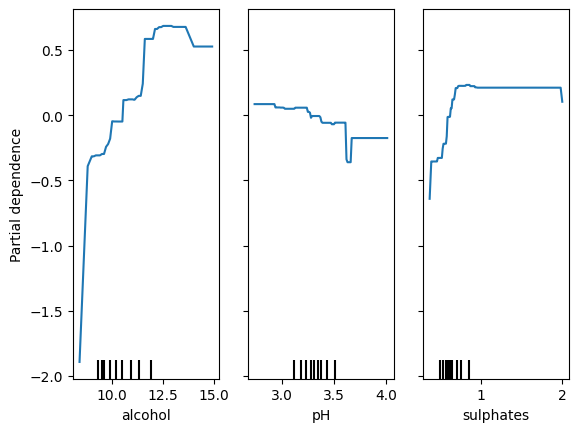

In [10]:
# Features of interest
features = ['alcohol', 'pH', 'sulphates']

# Calculating the average prediction for different values of the features
pdp = PartialDependenceDisplay.from_estimator(
    model, X_train, features=features)

### Interpreting the PDP for alcohol, pH and sulphates

First, it is important to consider the scale of the variables. For instance, the alcohol content is measured as a percentage, typically ranging from around 8% to 15%. This range is meaningful in the context of wine quality, as it reflects typical alcohol levels found in various wines.

The PDP for alcohol indicates that as the alcohol content increases, the wine quality score also tends to increase. This is expected, as wines with higher alcohol levels are often perceived to have a richer flavor profile, contributing positively to overall quality. The increasing trend in the PDP suggests that alcohol content has a positive effect on the wine quality score, providing a clear and intuitive insight into how this feature influences quality.

The trends for pH and sulphates are bit difficult to understand, because for pH, it seems like a steady decline in quality with an increase in pH, however, there is a significant dip around 3.6 pH in quality. For sulphates, there is a sharp increase in qualilty up to 1, and then a plateau in quality after that, suggesting that higher the sulphate content, the better the quality, but only up to a sulphate level of 1.

### Strengths and Weaknesses of PDPs

**Strengths**:
1. PDPs are easy to understand and interpret.
2. They show the marginal effect of a feature on the prediction.

**Weaknesses**:
1. PDPs assume that the features are independent of each other, which is not always the case.
2. They do not show the interaction between features.

## Individual Conditional Expectation (ICE) Plots  

### What is an ICE Plot?
ICE plots are similar to PDPs, but instead of showing the average effect of a feature, they show the effect of a feature on the prediction for each individual data point. This allows us to see how the feature affects the prediction for different data points.

### How to use an ICE Plot?
- Select a feature you want to analyze. Here, I chose the same features (i.e., `alcohol`, `pH`, and `sulphates`).
- Calculate the prediction of the model for different values of the feature for each data point.
- Plot the feature values on the x-axis and the predictions on the y-axis.

### How to interpret an ICE Plot?
The individual lines on an ICE plot show the effect of the feature on the prediction for each data point. The average effect of the feature is shown by the PDP (i.e., the plot above).

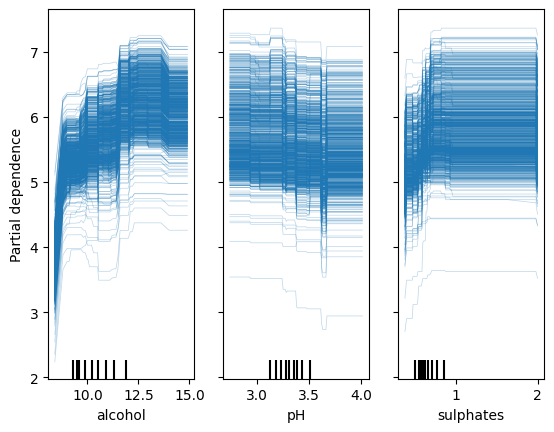

In [11]:
# Plotting the ICE plot
ice = PartialDependenceDisplay.from_estimator(
    model, X_train, features=features, kind='individual')


### Interpreting the ICE Plot for Median Income
As we can see from the plot above the individual lines show the effect of `alcohol`, `pH` and `sulphates` on the quality of wine for each data point. The lines are not smooth because they represent the effect of these features on the prediction for each individual data point. However, intuitively, we can tell that the average of these lines would be the same as the PDP plots from before.

### Strengths and Weaknesses of ICE Plots

**Strengths**:
1. Provides a more detailed view of the effect of a feature on the prediction.
2. Shows the effect of a feature on the prediction for each data point.

**Weaknesses**:
1. Could be a bit difficult to interpret if there are many data points.
2. Does not show the interaction between features.

## Accumulated Local Effects (ALE) Plots

### What is an ALE Plot?
ALE plots show the accumulated effect of a feature on the prediction. They are similar to PDPs but are more robust to feature interactions. ALE plots show the effect of a feature on the prediction while accounting for the effect of other features.

### How to use an ALE Plot?
- Select a feature you want to analyze. Here, I chose the the same features again.
- Calculate the prediction of the model for different values of the feature.
- Calculate the difference between the predictions for each value of the feature and the predictions for the previous value of the feature.
- Plot the feature values on the x-axis and the accumulated effects on the y-axis.

### How to interpret an ALE Plot?
- If the ALE plot is flat, it means that the feature has no effect on the prediction.
- If the ALE plot is increasing, it means that the feature has a positive effect on the prediction.
- If the ALE plot is decreasing, it means that the feature has a negative effect on the prediction.


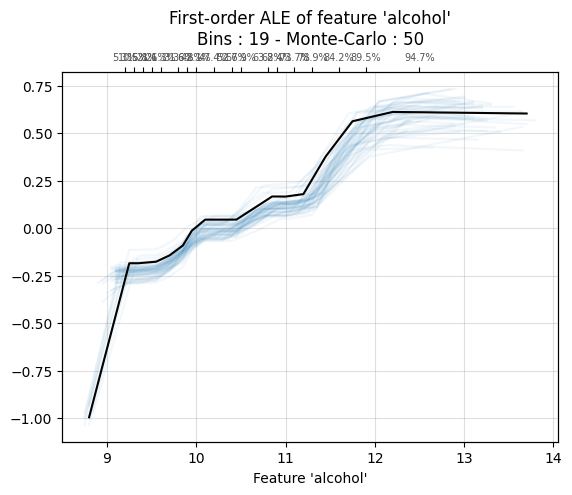

<Axes: title={'center': "First-order ALE of feature 'alcohol'\nBins : 19 - Monte-Carlo : 50"}, xlabel="Feature 'alcohol'">

In [15]:
# plottin the ALE plot
ale_plot(model, X_train, features=['alcohol'], bins=20, monte_carlo=True)


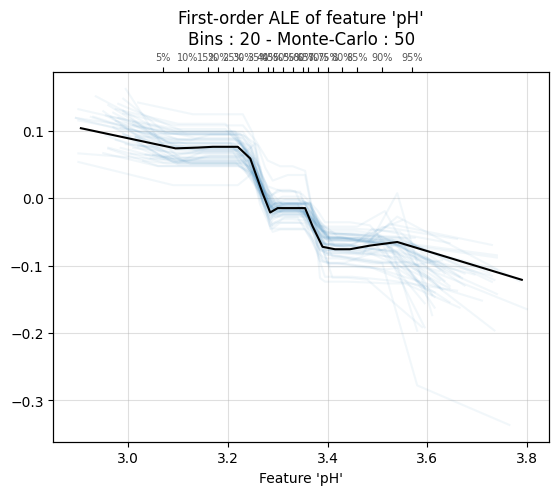

<Axes: title={'center': "First-order ALE of feature 'pH'\nBins : 20 - Monte-Carlo : 50"}, xlabel="Feature 'pH'">

In [16]:
ale_plot(model, X_train, features=['pH'], bins=20, monte_carlo=True)

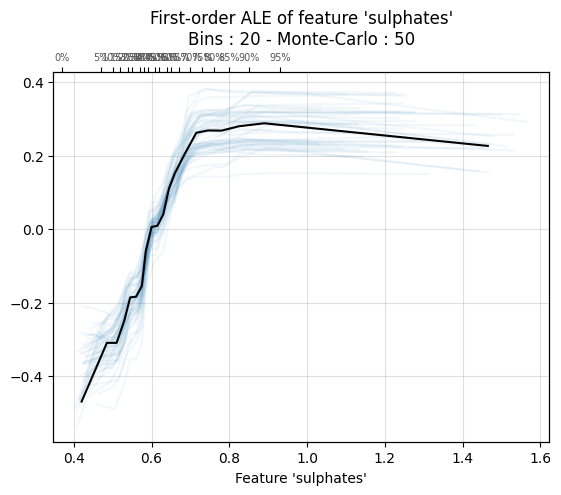

<Axes: title={'center': "First-order ALE of feature 'sulphates'\nBins : 20 - Monte-Carlo : 50"}, xlabel="Feature 'sulphates'">

In [17]:
ale_plot(model, X_train, features=['sulphates'], bins=20, monte_carlo=True)

### Interpreting the ALE Plot for Median Income
The ALE plots have been the most useful in my opinion, to understand the effect of the selected features on the quality of wine. Here, we can see that there is a `positive effect of alcohol content on wine quality`. The positive effect is ery significant at lower alcohol content percentages, and plateaus around an alcohol content of 12%, suggesting that drinkers' perception of the quality of wine does not change past this alcoholic content level.

Contrarily, there is a `negative effect of pH on wine quality`. This relationship does not seem to be as strong as the previous one, as the slope is not as steep. Nevertheless, we can tell that the lower the pH, i.e., around 3.0, the better the quality of wine.

Laslty, the `effect of sulphates on wine quality seems to be positive`. However, this relationship seems to be a bit more complex, as a sharp increase in quality of wine with sulphate content up to around 0.75, is followed by a plateau and steady decline in wine quality past a sulphate level of 0.75.

### Strengths and Weaknesses of ALE Plots

**Strengths**:
1. More robust to feature interactions.
2. Provides a more accurate view of the effect of a feature on the prediction.

**Weaknesses**:
1. Can be difficult to interpret if there are many data points.
2. There is a dependence on intervals. Therefore, depending on the intervals chosen, the ALE plot may look different.